<a href="https://colab.research.google.com/github/armen1s/CorrelationTEST/blob/main/Test_Stage_Mark_coef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libs

In [ ]:
#@title Install libs
!pip install catboost
!pip install ccxt

"""
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
"""

!pip install TA-Lib-Precompiled
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.4 requires

In [ ]:
from logging import warning
#@title Load libs
import numpy as np

# Data Management
import pandas as pd

# Machine Learning
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

#Sampling Methods
from imblearn.over_sampling import ADASYN

#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Binary Classification Specific Metrics
from sklearn.metrics import RocCurveDisplay as plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

from hyperopt import fmin, tpe, hp
from pandas_datareader.data import DataReader

import json
from datetime import datetime
import talib as ta
import ccxt

import matplotlib.pyplot as plt

from tqdm import tqdm
import pickle as pk
import joblib

#Functions

In [ ]:
import numpy as np
import pandas as pd
import talib as ta


def get_indicators(data, timeframes, volatility_look_back, supertrend_multiplier=3):
    """
    Возвращает датафрейм с индикаторами:
        – классические (ATR, RSI, VWAP, Supertrend …)
        – «нишумовые» фичи для распознавания нулевого класса
    """
    df = data.copy()

    # ----------------------------------------------------------
    # ❶ Цикл по каждому тайм‑фрейму
    # ----------------------------------------------------------
    for timeframe in timeframes:
        # --- базовые индикаторы
        df[f'ATR_{timeframe}']  = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        df[f'RSI_{timeframe}']  = ta.RSI(df['close'], timeperiod=timeframe)


        df[f'CCI_{timeframe}']  = ta.CCI(df['high'], df['low'], df['close'], timeperiod=timeframe)

        # --- DPO
        offset = timeframe // 2 + 1
        sma    = df['close'].rolling(window=timeframe).mean()
        df[f'DPO_{timeframe}'] = df['close'].shift(offset) - sma
        dpo_range = df[f'DPO_{timeframe}'].rolling(window=timeframe).apply(lambda x: x.max() - x.min())
        df[f'DPO_flat_{timeframe}'] = (dpo_range < 0.01).astype(int)




        # --- Supertrend
        hl2 = (df['high'] + df['low']) / 2
        atr = ta.ATR(df['high'], df['low'], df['close'], timeperiod=timeframe)
        upper_band = hl2 + supertrend_multiplier * atr
        lower_band = hl2 - supertrend_multiplier * atr

        supertrend = [np.nan] * len(df)
        in_uptrend = [True] * len(df)

        for i in range(timeframe, len(df)):
            close_i   = df['close'].iloc[i]

            if close_i > upper_band.iloc[i - 1]:
                in_uptrend[i] = True
            elif close_i < lower_band.iloc[i - 1]:
                in_uptrend[i] = False
            else:
                in_uptrend[i] = in_uptrend[i - 1]
                if in_uptrend[i] and lower_band.iloc[i] < lower_band.iloc[i - 1]:
                    lower_band.iloc[i] = lower_band.iloc[i - 1]
                if not in_uptrend[i] and upper_band.iloc[i] > upper_band.iloc[i - 1]:
                    upper_band.iloc[i] = upper_band.iloc[i - 1]

            supertrend[i] = lower_band.iloc[i] if in_uptrend[i] else upper_band.iloc[i]

        df[f'Supertrend_{timeframe}']        = supertrend
        df[f'Supertrend_trend_{timeframe}']  = in_uptrend

        # ------------------------------------------------------
        # ❷ «Тишинные» фичи для нулевого класса
        # ------------------------------------------------------
        # амплитуда и тело свечи
        df['range_abs']   = df['high'] - df['low']
        df['candle_body'] = (df['open'] - df['close']).abs()





    # ----------------------------------------------------------
    # ❸ Глобальные метрики
    # ----------------------------------------------------------
    df["returns"]    = (df["close"] / df["close"].shift(volatility_look_back)) - 1
    df["range"]      = (df["high"] / df["low"]) - 1
    df["volatility"] = df["returns"].rolling(window=volatility_look_back).std(ddof=0)

    # Volume‑based
    df['ADL'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ROC'] = ta.ROC(df['close'], timeperiod=volatility_look_back)


    # Momentum
    slowk, _ = ta.STOCH(df['high'], df['low'], df['close'])
    df['Stoch_Oscillator'] = slowk
    df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
    df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)

    return df

In [ ]:
#@title New Mark Function
def get_shifts(df, K=4): #(data, K=4):
    #df=data.copy()
    for i in range(K):
        name_back=f'shift_{i}'
        name_frorward=f'shift_-{i}'
        df[name_back]=df['close'].shift(i)
        df[name_frorward]=df['close'].shift(-i)
    df.dropna(inplace=True)
    #return df

def get_coefs(df, K=4): #data, K=4):
    #df=data.copy()

    #get means
    back_col_names=[f'shift_{i}' for i in range(K)]
    frorward_col_names=[f'shift_-{i}' for i in range(K)]
    back_result=[i.mean() for i in df[back_col_names].values]
    frorward_result=[i.mean() for i in df[frorward_col_names].values]
    df['mean_back']=back_result
    df['mean_frorward']=frorward_result

    #get coefs
    df['coef']=(df['mean_frorward']-df['mean_back'])/df['mean_back']
    #return df

def get_classes(df,std_corrector=1): #data, std_corrector=1):
    #df=data.copy()
    long_thold=df['coef'][df['coef']>=0].mean()-df['coef'][df['coef']>=0].std()/std_corrector
    short_thold=df['coef'][df['coef']<0].mean()+df['coef'][df['coef']<0].std()/std_corrector
    df['target']=0
    df['target'][df['coef']>long_thold]=1
    df['target'][df['coef']<short_thold]=2 #-1
    #return df

def get_lbls(data, K=4, std_corrector=1):
    df=data.copy()
    get_shifts(df, K)
    get_coefs(df, K)
    get_classes(df, std_corrector)

    return df

In [ ]:
#@title Indicators adding function
def add_indicators(data,
                   timeframes = [2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 18, 22, 30 ],
                   volatility_look_back= 2):
    df_w_indicators=get_indicators(data,
                               timeframes,
                               volatility_look_back)
    df_w_indicators.dropna(inplace=True)

    # Apply np.isinf and np.isnan to numerical columns only
    numerical_cols = df_w_indicators.select_dtypes(include=np.number).columns
    # Recalculate inf_mask using df_cleaned instead of df_w_indicators
    inf_mask = np.isinf(df_w_indicators[numerical_cols]) | np.isnan(df_w_indicators[numerical_cols])

    # Update the rest of the code accordingly
    df_cleaned = df_w_indicators[~inf_mask.any(axis=1)]
    # Use numerical_cols for column selection to ensure alignment
    df = df_cleaned.loc[:, numerical_cols[~inf_mask.any(axis=0)]]
    df.dropna(inplace=True)
    return df

#Data preparation

In [ ]:
#@title Read csv
five_min_df = pd.read_csv('/content/2025-01-01_2025-04-13_5m_bybit_btcusdt_ohlcv.csv')

# Удаляем строки, где timestamp равен '2' (или содержит некорректные данные)
five_min_df = five_min_df[five_min_df['timestamp'] != '2']

# Удаляем строки с пустым volume
five_min_df = five_min_df.dropna(subset=['volume'])

# Преобразуем столбец 'timestamp' в datetime
five_min_df['timestamp'] = pd.to_datetime(five_min_df['timestamp'])

# Устанавливаем столбец 'timestamp' в качестве индекса
five_min_df.set_index('timestamp', inplace=True)

five_min_df = five_min_df.tail(9000)

print(f"Исходный размер DataFrame: {len(five_min_df)}")

Исходный размер DataFrame: 9000


In [ ]:
#@title Primary split
train_splitter=round(len(five_min_df)*0.7)
train=five_min_df.iloc[:train_splitter]


val_splitter=round(len(five_min_df)*0.85)
val=five_min_df.iloc[:val_splitter]

test=five_min_df.copy()

In [ ]:
#@title Adding indicators to train/test/val
train_w_ind=add_indicators(train)
val_w_ind=add_indicators(val)
test_w_ind=add_indicators(test)

<ipython-input-2-1587400692>:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PSAR'] = ta.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.2)
<ipython-input-2-1587400692>:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ADX']  = ta.ADX(df['high'], df['low'], df['close'], timeperiod=volatility_look_back)
<ipython-input-2-1587400692>:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [ ]:
#@title Add target (New)

STD_CORRECTOR = 2 #@param {type: "integer"}
K = 4 #@param {type: "integer"}

train_input=get_lbls(train_w_ind, K=K, std_corrector=STD_CORRECTOR)
val_input=get_lbls(val_w_ind, K=K, std_corrector=STD_CORRECTOR)
test_input=get_lbls(test_w_ind, K=K, std_corrector=STD_CORRECTOR)
train_input=train_input.reset_index()
val_input=val_input.reset_index()
test_input=test_input.reset_index()

drop_cols=[f'shift_-{i}' for i in range(K)]
#drop_cols.append('mean_frorward')
test_input=test_input.drop(columns=drop_cols)
val_input=val_input.drop(columns=drop_cols)
train_input=train_input.drop(columns=drop_cols)


#keys=list(train_input.keys())
#keys.append('target')
#df.head()
#df['target'].hist()

<ipython-input-3-450657997>:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['target'][df['coef']>long_thold]=1
<ipython-input-3-450657997>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

S

<Axes: >

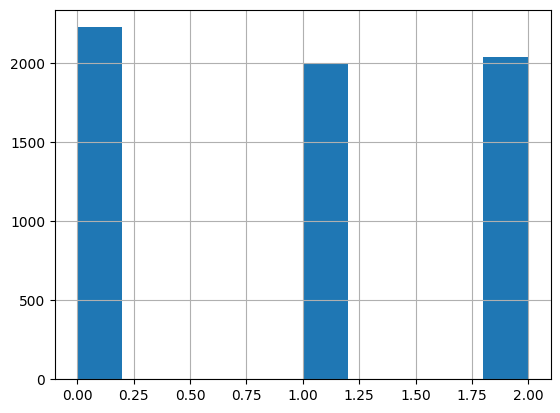

In [ ]:
#@title Look at class balance
train_input['target'].hist()

In [ ]:
#@title Новая трёхуровневая разметка данных

import numpy as np
import pandas as pd

# --- Параметры для разметки ---
# Период для анализа (количество будущих и прошлых свечей)
K = 4 #@param {type: "integer"}

# Квантиль для определения "флета". Все движения ниже этого порога считаются флетом.
FLAT_QUANTILE = 0.3 #@param {type: "slider", min:0.1, max:0.9, step:0.05}

# Квантили для определения силы движения (для аномальных данных)
# Например, [0.33, 0.66] разделит аномалии на 3 примерно равные группы.
STRENGTH_QUANTILES = [0.4, 0.8] #@param

def calculate_movement_coefficient(df, k):
    """
    Рассчитывает коэффициент движения цены.

    Для каждой точки данных функция анализирует 'k' прошлых и 'k' будущих цен закрытия.
    Коэффициент вычисляется как относительное изменение средней будущей цены
    по отношению к средней прошлой цене.

    Args:
        df (pd.DataFrame): DataFrame с колонкой 'close'.
        k (int): Количество свечей для анализа в прошлом и будущем.

    Returns:
        pd.Series: Серия с коэффициентами движения.
    """
    # Создаем сдвиги для будущих и прошлых цен
    for i in range(1, k + 1):
        df[f'shift_past_{i}'] = df['close'].shift(i)
        df[f'shift_future_{i}'] = df['close'].shift(-i)

    # Определяем имена колонок для удобства
    past_cols = [f'shift_past_{i}' for i in range(1, k + 1)]
    future_cols = [f'shift_future_{i}' for i in range(1, k + 1)]

    # Считаем среднее для прошлых и будущих цен
    df['mean_past'] = df[past_cols].mean(axis=1)
    df['mean_future'] = df[future_cols].mean(axis=1)

    # Рассчитываем коэффициент и его абсолютное значение (магнитуду)
    df['coef'] = (df['mean_future'] - df['mean_past']) / df['mean_past']
    df['movement_magnitude'] = df['coef'].abs()

    # Удаляем временные колонки
    df.drop(columns=past_cols + future_cols + ['mean_past', 'mean_future'], inplace=True)

    return df['coef']


def apply_labeling_strategy(df, flat_threshold, strength_thresholds):
    """
    Применяет трёхуровневую разметку к DataFrame на основе вычисленных порогов.

    Args:
        df (pd.DataFrame): DataFrame с колонками 'coef' и 'movement_magnitude'.
        flat_threshold (float): Порог для определения флета.
        strength_thresholds (list): Список из двух порогов для определения силы.

    Returns:
        pd.DataFrame: DataFrame с новыми колонками:
                      target_anomaly, target_direction, target_strength.
    """
    # 1. Разметка "Аномалия vs. Флет"
    # Класс 1 - Флет, Класс 2 - Аномалия
    df['target_anomaly'] = np.where(df['movement_magnitude'] < flat_threshold, 1, 2)

    # 2. Разметка "Направление движения"
    # Класс 0 - для Флета, 1 - Вверх, 2 - Вниз
    df['target_direction'] = 0
    df.loc[(df['target_anomaly'] == 2) & (df['coef'] > 0), 'target_direction'] = 1
    df.loc[(df['target_anomaly'] == 2) & (df['coef'] < 0), 'target_direction'] = 2

    # 3. Разметка "Сила движения"
    # Класс 0 - для Флета, 1 - Слабое, 2 - Среднее, 3 - Сильное
    df['target_strength'] = 0
    df.loc[
        (df['target_anomaly'] == 2) & (df['movement_magnitude'] < strength_thresholds[0]),
        'target_strength'
    ] = 1
    df.loc[
        (df['target_anomaly'] == 2) & (df['movement_magnitude'] >= strength_thresholds[0]) & (df['movement_magnitude'] < strength_thresholds[1]),
        'target_strength'
    ] = 2
    df.loc[
        (df['target_anomaly'] == 2) & (df['movement_magnitude'] >= strength_thresholds[1]),
        'target_strength'
    ] = 3

    return df


# --- Начало процесса разметки ---

# Создаем копии, чтобы не изменять оригинальные датафреймы
train_labeled = train_w_ind.copy()
val_labeled = val_w_ind.copy()
test_labeled = test_w_ind.copy()

print("1. Расчет коэффициента движения для всех наборов данных...")
calculate_movement_coefficient(train_labeled, K)
calculate_movement_coefficient(val_labeled, K)
calculate_movement_coefficient(test_labeled, K)

print(f"2. Вычисление порогов на обучающей выборке (train_labeled)...")
# Важно: удаляем NaN, которые появились из-за сдвигов, перед вычислением порогов
train_cleaned = train_labeled.dropna(subset=['coef', 'movement_magnitude'])

# Вычисляем порог для флета
flat_threshold = train_cleaned['movement_magnitude'].quantile(FLAT_QUANTILE)
print(f"   - Порог для флета (квантиль {FLAT_QUANTILE}): {flat_threshold:.6f}")

# Вычисляем пороги для силы движения только на "аномальных" данных
anomaly_data = train_cleaned[train_cleaned['movement_magnitude'] >= flat_threshold]
strength_thresholds = [
    anomaly_data['movement_magnitude'].quantile(STRENGTH_QUANTILES[0]),
    anomaly_data['movement_magnitude'].quantile(STRENGTH_QUANTILES[1])
]
print(f"   - Пороги для силы (квантили {STRENGTH_QUANTILES}): {strength_thresholds[0]:.6f}, {strength_thresholds[1]:.6f}")

print("3. Применение разметки ко всем наборам данных...")
train_final = apply_labeling_strategy(train_labeled, flat_threshold, strength_thresholds)
val_final = apply_labeling_strategy(val_labeled, flat_threshold, strength_thresholds)
test_final = apply_labeling_strategy(test_labeled, flat_threshold, strength_thresholds)

# Очистка от NaN, возникших из-за сдвигов
train_final.dropna(inplace=True)
val_final.dropna(inplace=True)
test_final.dropna(inplace=True)

# Преобразуем таргеты в целочисленный тип
for col in ['target_anomaly', 'target_direction', 'target_strength']:
    train_final[col] = train_final[col].astype(int)
    val_final[col] = val_final[col].astype(int)
    test_final[col] = test_final[col].astype(int)

print("\nРазметка завершена. Созданы датафреймы: train_final, val_final, test_final.")
print(f"Размер train_final: {train_final.shape}")
print(f"Размер val_final: {val_final.shape}")
print(f"Размер test_final: {test_final.shape}")

1. Расчет коэффициента движения для всех наборов данных...
2. Вычисление порогов на обучающей выборке (train_labeled)...
   - Порог для флета (квантиль 0.3): 0.000690
   - Пороги для силы (квантили [0.4, 0.8]): 0.001512, 0.003083
3. Применение разметки ко всем наборам данных...

Разметка завершена. Созданы датафреймы: train_final, val_final, test_final.
Размер train_final: (6268, 98)
Размер val_final: (7618, 98)
Размер test_final: (8968, 98)


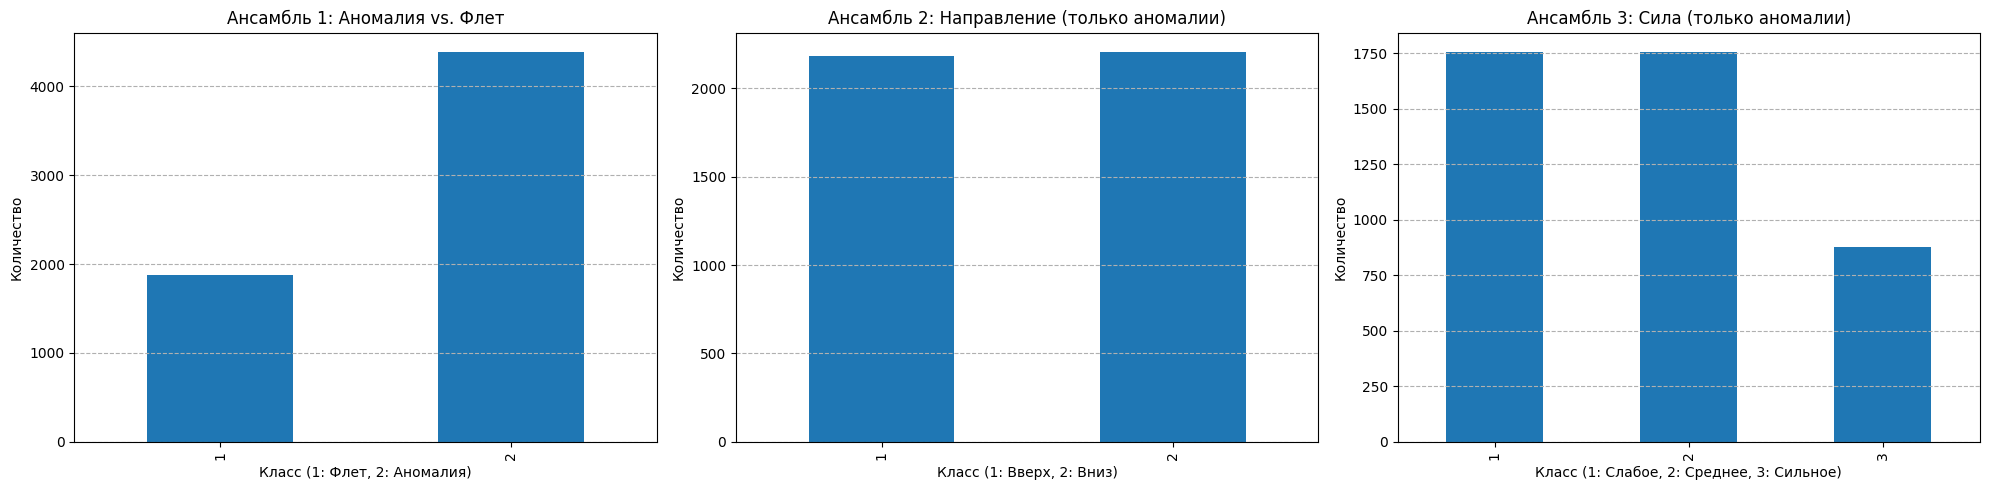

Баланс классов в обучающей выборке (train_final):

--- 1. Аномалия vs. Флет ---
target_anomaly
1    0.300096
2    0.699904
Name: proportion, dtype: float64

--- 2. Направление (среди аномалий) ---
target_direction
1    0.497379
2    0.502621
Name: proportion, dtype: float64

--- 3. Сила (среди аномалий) ---
target_strength
1    0.400046
2    0.399818
3    0.200137
Name: proportion, dtype: float64


In [ ]:

#@title Анализ баланса новых классов

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# --- Ансамбль 1: Аномалия vs. Флет ---
train_final['target_anomaly'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[0],
    title='Ансамбль 1: Аномалия vs. Флет',
    xlabel='Класс (1: Флет, 2: Аномалия)',
    ylabel='Количество'
)
axes[0].grid(axis='y', linestyle='--')

# --- Ансамбль 2: Направление ---
# Исключаем класс 0 (флет) из визуализации для наглядности
train_final[train_final['target_direction'] != 0]['target_direction'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[1],
    title='Ансамбль 2: Направление (только аномалии)',
    xlabel='Класс (1: Вверх, 2: Вниз)',
    ylabel='Количество'
)
axes[1].grid(axis='y', linestyle='--')


# --- Ансамбль 3: Сила ---
# Исключаем класс 0 (флет) из визуализации
train_final[train_final['target_strength'] != 0]['target_strength'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[2],
    title='Ансамбль 3: Сила (только аномалии)',
    xlabel='Класс (1: Слабое, 2: Среднее, 3: Сильное)',
    ylabel='Количество'
)
axes[2].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Выведем также точные цифры
print("Баланс классов в обучающей выборке (train_final):\n")
print("--- 1. Аномалия vs. Флет ---")
print(train_final['target_anomaly'].value_counts(normalize=True).sort_index())
print("\n--- 2. Направление (среди аномалий) ---")
print(train_final[train_final['target_anomaly'] == 2]['target_direction'].value_counts(normalize=True).sort_index())
print("\n--- 3. Сила (среди аномалий) ---")
print(train_final[train_final['target_anomaly'] == 2]['target_strength'].value_counts(normalize=True).sort_index())

Этап 1: Расчет коэффициентов движения...
Коэффициенты рассчитаны.

Этап 2: Определение порогов на обучающей выборке...
Вычисление порогов на обучающей выборке...
  - Ст. отклонение коэффициента: 0.002422
  - Порог для флета (std * 0.7): 0.001695
  - Пороги для силы (квантили [0.4, 0.8]): 0.002416, 0.004200
Пороги определены.

Этап 3: Применение разметки ко всем наборам данных...
Разметка завершена.

Размер train_final: (6268, 98)
Размер val_final: (7618, 98)
Размер test_final: (8968, 98)

Пример финальных данных (train_final):


,close,coef,movement_magnitude,target_anomaly,target_direction,target_strength
timestamp,,,,,,
2025-03-12 20:40:00,83138.11,-0.000404,0.000404,1,0,0
2025-03-12 20:45:00,83105.35,-0.000155,0.000155,1,0,0
2025-03-12 20:50:00,83048.37,0.000709,0.000709,1,0,0
2025-03-12 20:55:00,83117.22,0.001399,0.001399,1,0,0
2025-03-12 21:00:00,83237.04,0.001442,0.001442,1,0,0


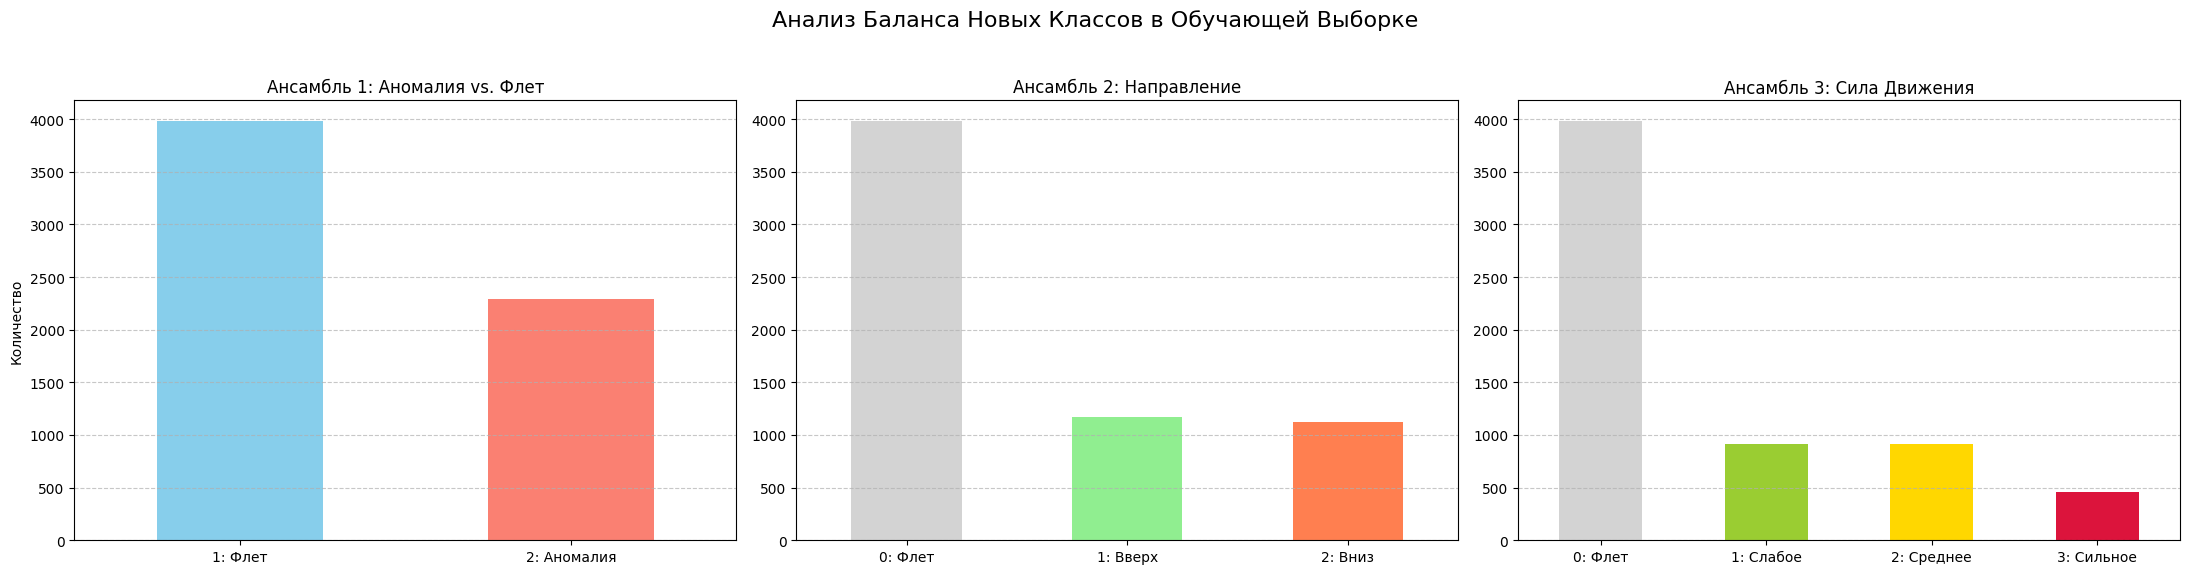

In [ ]:
#@title Новая усовершенствованная трёхуровневая разметка данных

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Параметры для разметки ---

# Период для анализа (количество будущих и прошлых свечей)
K = 4 #@param {type: "integer"}

# --- Параметры для Ансамбля 1: "Аномалия vs Флет" ---
# Множитель стандартного отклонения для определения порога флета.
# Движения, магнитуда которых меньше (std_dev * multiplier), считаются флетом.
# Это позволяет адаптироваться к волатильности.
STD_MULTIPLIER = 0.7 #@param {type: "slider", min:0.1, max:2.0, step:0.1}

# --- Параметры для Ансамбля 3: "Сила Движения" ---
# Квантили для разделения аномалий на слабое, среднее и сильное движение.
STRENGTH_QUANTILES = [0.4, 0.8] #@param


def calculate_movement_coefficient(df, k):
    """
    Рассчитывает коэффициент движения цены и его магнитуду.

    Для каждой точки данных функция анализирует 'k' прошлых и 'k' будущих цен закрытия.
    Коэффициент вычисляется как относительное изменение средней будущей цены
    по отношению к средней прошлой цене.

    Args:
        df (pd.DataFrame): DataFrame с колонкой 'close'.
        k (int): Количество свечей для анализа в прошлом и будущем.

    Returns:
        pd.DataFrame: DataFrame с новыми колонками 'coef' и 'movement_magnitude'.
    """
    # Создаем копию, чтобы не изменять оригинальный DataFrame
    df_copy = df.copy()

    # Создаем сдвиги для будущих и прошлых цен
    for i in range(1, k + 1):
        df_copy[f'shift_past_{i}'] = df_copy['close'].shift(i)
        df_copy[f'shift_future_{i}'] = df_copy['close'].shift(-i)

    # Определяем имена колонок
    past_cols = [f'shift_past_{i}' for i in range(1, k + 1)]
    future_cols = [f'shift_future_{i}' for i in range(1, k + 1)]

    # Считаем среднее
    df_copy['mean_past'] = df_copy[past_cols].mean(axis=1)
    df_copy['mean_future'] = df_copy[future_cols].mean(axis=1)

    # Рассчитываем коэффициент и его абсолютное значение (магнитуду)
    df_copy['coef'] = (df_copy['mean_future'] - df_copy['mean_past']) / df_copy['mean_past']
    df_copy['movement_magnitude'] = df_copy['coef'].abs()

    # Удаляем временные колонки, оставляя только нужные
    df_copy.drop(columns=past_cols + future_cols + ['mean_past', 'mean_future'], inplace=True)

    # Очищаем от NaN, которые появились из-за сдвигов
    df_copy.dropna(subset=['coef', 'movement_magnitude'], inplace=True)

    return df_copy


def get_labeling_thresholds(train_df, std_multiplier, strength_quantiles):
    """
    Вычисляет все необходимые пороги ИСКЛЮЧИТЕЛЬНО на обучающих данных.

    Args:
        train_df (pd.DataFrame): Обучающий DataFrame с колонками 'coef' и 'movement_magnitude'.
        std_multiplier (float): Множитель стандартного отклонения для порога флета.
        strength_quantiles (list): Квантили для порогов силы.

    Returns:
        dict: Словарь с вычисленными порогами.
    """
    print("Вычисление порогов на обучающей выборке...")

    # 1. Порог для "Аномалия vs Флет"
    # Рассчитываем стандартное отклонение коэффициента на обучающей выборке
    coef_std_dev = train_df['coef'].std()
    flat_threshold = coef_std_dev * std_multiplier
    print(f"  - Ст. отклонение коэффициента: {coef_std_dev:.6f}")
    print(f"  - Порог для флета (std * {std_multiplier}): {flat_threshold:.6f}")

    # 2. Пороги для "Силы движения"
    # Фильтруем только аномальные движения для расчета порогов силы
    anomaly_data = train_df[train_df['movement_magnitude'] >= flat_threshold]

    if len(anomaly_data) == 0:
        print("  - Внимание: Не найдено аномальных движений для расчета порогов силы. Используются нулевые пороги.")
        strength_thresholds_values = [0, 0]
    else:
        strength_thresholds_values = [
            anomaly_data['movement_magnitude'].quantile(strength_quantiles[0]),
            anomaly_data['movement_magnitude'].quantile(strength_quantiles[1])
        ]
    print(f"  - Пороги для силы (квантили {strength_quantiles}): {strength_thresholds_values[0]:.6f}, {strength_thresholds_values[1]:.6f}")

    return {
        "flat_threshold": flat_threshold,
        "strength_thresholds": strength_thresholds_values
    }


def apply_labeling_strategy(df, thresholds):
    """
    Применяет трёхуровневую разметку к DataFrame на основе вычисленных порогов.

    Args:
        df (pd.DataFrame): DataFrame, к которому применяется разметка.
        thresholds (dict): Словарь с порогами.

    Returns:
        pd.DataFrame: DataFrame с новыми целевыми колонками.
    """
    # Извлекаем пороги
    flat_threshold = thresholds['flat_threshold']
    strength_thresholds = thresholds['strength_thresholds']

    # 1. Разметка "Аномалия vs. Флет"
    # Класс 1 - Флет, Класс 2 - Аномалия
    df['target_anomaly'] = np.where(df['movement_magnitude'] < flat_threshold, 1, 2)

    # 2. Разметка "Направление движения"
    # Класс 0 - для Флета, 1 - Вверх, 2 - Вниз
    df['target_direction'] = 0
    df.loc[(df['target_anomaly'] == 2) & (df['coef'] > 0), 'target_direction'] = 1
    df.loc[(df['target_anomaly'] == 2) & (df['coef'] < 0), 'target_direction'] = 2

    # 3. Разметка "Сила движения"
    # Класс 0 - для Флета, 1 - Слабое, 2 - Среднее, 3 - Сильное
    df['target_strength'] = 0
    # Слабое движение
    df.loc[
        (df['target_anomaly'] == 2) & (df['movement_magnitude'] < strength_thresholds[0]),
        'target_strength'
    ] = 1
    # Среднее движение
    df.loc[
        (df['target_anomaly'] == 2) &
        (df['movement_magnitude'] >= strength_thresholds[0]) &
        (df['movement_magnitude'] < strength_thresholds[1]),
        'target_strength'
    ] = 2
    # Сильное движение
    df.loc[
        (df['target_anomaly'] == 2) & (df['movement_magnitude'] >= strength_thresholds[1]),
        'target_strength'
    ] = 3

    # Преобразуем таргеты в целочисленный тип для совместимости с моделями
    for col in ['target_anomaly', 'target_direction', 'target_strength']:
        df[col] = df[col].astype(int)

    return df

# --- Начало процесса разметки ---

# 1. Рассчитываем коэффициенты для всех наборов данных
print("Этап 1: Расчет коэффициентов движения...")
train_with_coef = calculate_movement_coefficient(train_w_ind, K)
val_with_coef = calculate_movement_coefficient(val_w_ind, K)
test_with_coef = calculate_movement_coefficient(test_w_ind, K)
print("Коэффициенты рассчитаны.\n")

# 2. Вычисляем пороги ТОЛЬКО на обучающем наборе
print("Этап 2: Определение порогов на обучающей выборке...")
labeling_thresholds = get_labeling_thresholds(train_with_coef, STD_MULTIPLIER, STRENGTH_QUANTILES)
print("Пороги определены.\n")

# 3. Применяем разметку с едиными порогами ко всем наборам
print("Этап 3: Применение разметки ко всем наборам данных...")
train_final = apply_labeling_strategy(train_with_coef, labeling_thresholds)
val_final = apply_labeling_strategy(val_with_coef, labeling_thresholds)
test_final = apply_labeling_strategy(test_with_coef, labeling_thresholds)
print("Разметка завершена.\n")


# --- Финальная проверка ---
print(f"Размер train_final: {train_final.shape}")
print(f"Размер val_final: {val_final.shape}")
print(f"Размер test_final: {test_final.shape}")

print("\nПример финальных данных (train_final):")
display(train_final[['close', 'coef', 'movement_magnitude', 'target_anomaly', 'target_direction', 'target_strength']].head())

# --- Визуализация баланса классов ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Анализ Баланса Новых Классов в Обучающей Выборке', fontsize=16)

# Ансамбль 1: Аномалия vs. Флет
train_final['target_anomaly'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=['skyblue', 'salmon'], rot=0
)
axes[0].set_title('Ансамбль 1: Аномалия vs. Флет', fontsize=12)
axes[0].set_xticklabels(['1: Флет', '2: Аномалия'])
axes[0].set_xlabel('')
axes[0].set_ylabel('Количество')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Ансамбль 2: Направление
direction_counts = train_final['target_direction'].value_counts().sort_index()
direction_counts.plot(
    kind='bar', ax=axes[1], color=['lightgray', 'lightgreen', 'coral'], rot=0
)
axes[1].set_title('Ансамбль 2: Направление', fontsize=12)
axes[1].set_xticklabels(['0: Флет', '1: Вверх', '2: Вниз'])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


# Ансамбль 3: Сила
strength_counts = train_final['target_strength'].value_counts().sort_index()
strength_counts.plot(
    kind='bar', ax=axes[2], color=['lightgray', 'yellowgreen', 'gold', 'crimson'], rot=0
)
axes[2].set_title('Ансамбль 3: Сила Движения', fontsize=12)
axes[2].set_xticklabels(['0: Флет', '1: Слабое', '2: Среднее', '3: Сильное'])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()